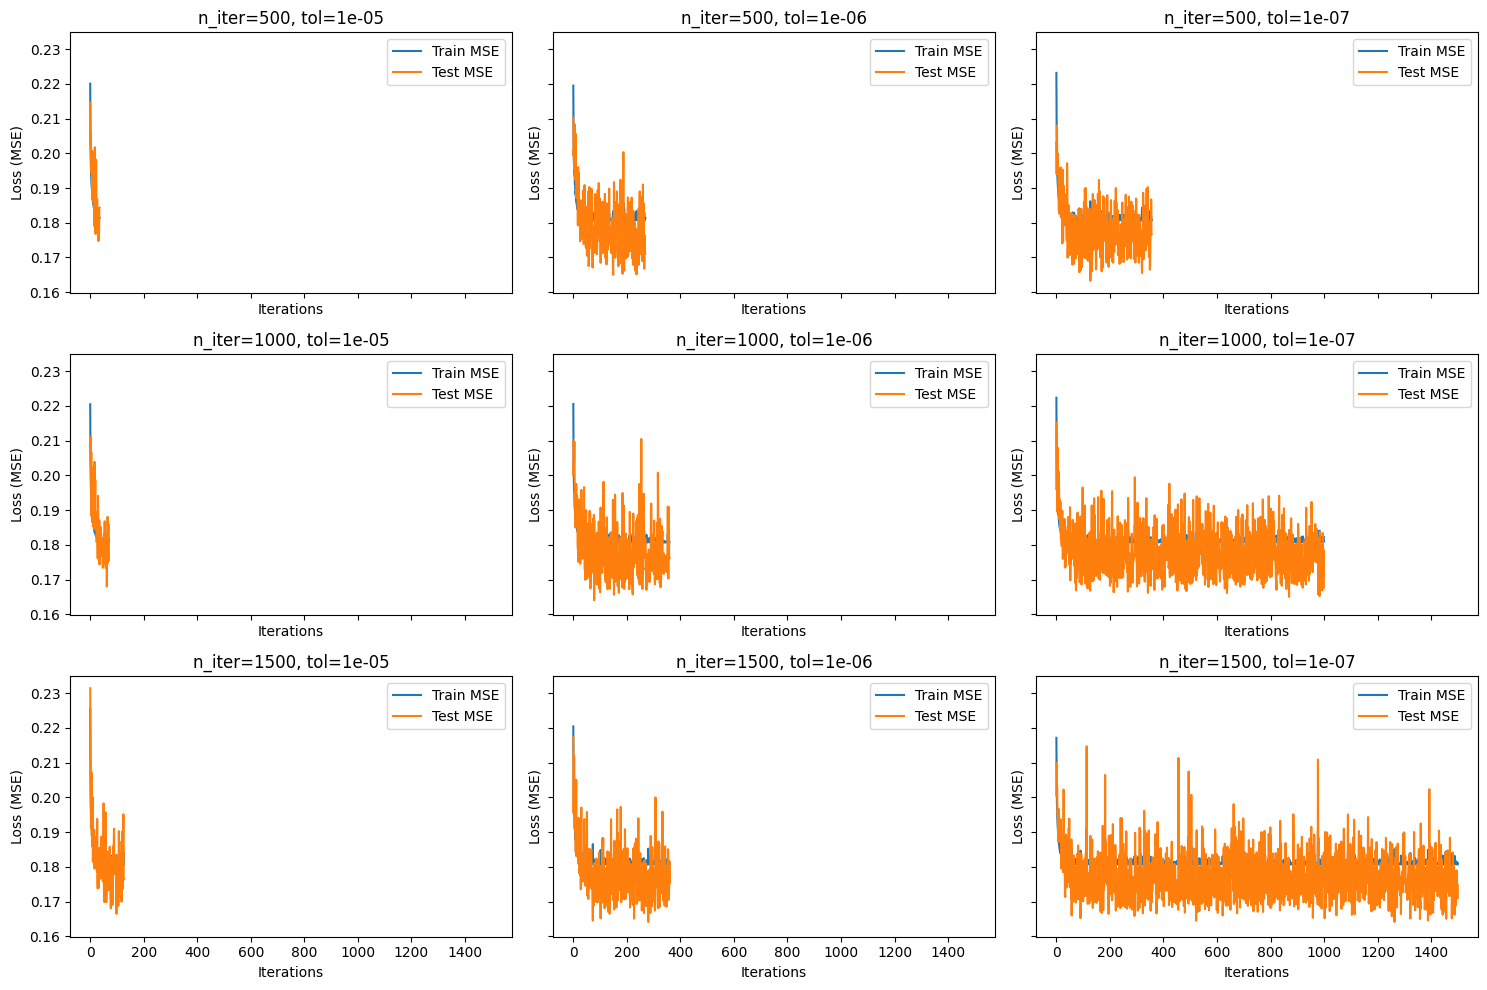

Log file has been saved.


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
import json
from ucimlrepo import fetch_ucirepo

auto_mpg = fetch_ucirepo(id=9)
data = auto_mpg['data']['features'].copy()
data['mpg'] = auto_mpg['data']['targets']
data['car_name'] = auto_mpg['data']['ids']

# Handle missing values and drop unnecessary columns
data.dropna(subset=['horsepower'], inplace=True)
data.drop(columns=['car_name'], inplace=True)

# Normalize/scale the data
scaler = StandardScaler()
scaled_data_array = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data_array, columns=data.columns)

# Split into features and target variable
X = scaled_data.drop('mpg', axis=1)
y = scaled_data['mpg']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define ranges for n_iter and tolerance
n_iter_values = [500, 1000, 1500]
tolerance_values = [1e-5, 1e-6, 1e-7]

# Assuming X_train, X_test, y_train, y_test are already defined

# Function to train the model and record the losses
def train_and_record_metrics(X_train, y_train, n_iter, tolerance):
    model = SGDRegressor(max_iter=1, tol=None, warm_start=True)
    train_losses = []
    test_losses = []
    train_variances = []
    test_variances = []

    for _ in range(n_iter):
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_loss = mean_squared_error(y_train, y_train_pred)
        test_loss = mean_squared_error(y_test, y_test_pred)

        train_variance = explained_variance_score(y_train, y_train_pred)
        test_variance = explained_variance_score(y_test, y_test_pred)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_variances.append(train_variance)
        test_variances.append(test_variance)

        if len(train_losses) > 1 and abs(train_losses[-2] - train_losses[-1]) < tolerance:
            break

    return model, train_losses, test_losses, train_variances, test_variances

# Create a grid of subplots
fig, axs = plt.subplots(len(n_iter_values), len(tolerance_values), figsize=(15, 10), sharex=True, sharey=True)

# Log file data structure
log_data = []

# Plotting results
for i, n_iter in enumerate(n_iter_values):
    for j, tolerance in enumerate(tolerance_values):
        model, train_losses, test_losses, train_variances, test_variances = train_and_record_metrics(X_train, y_train, n_iter, tolerance)

        # Plotting
        ax = axs[i, j]
        ax.plot(train_losses, label='Train MSE')
        ax.plot(test_losses, label='Test MSE')
        ax.set_title(f'n_iter={n_iter}, tol={tolerance}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss (MSE)')
        ax.legend()

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        coefficients = model.coef_

        # Log the results
        log_entry = {
            'n_iter': n_iter,
            'tolerance': tolerance,
            'iterations': len(train_losses),
            'learning_rate': 'optimal',
            'train_mse': train_losses[-1],
            'test_mse': test_losses[-1],
            'train_explained_variance': train_variances[-1],
            'test_explained_variance': test_variances[-1],
            'r2': r2,
            'coefficients': coefficients.tolist()
        }
        log_data.append(log_entry)

plt.tight_layout()
plt.show()

# Save the log data to a file
with open('part2_log.txt', 'w') as f:
    json.dump(log_data, f, indent=4)

# Print a message to confirm the log file has been saved
print("Log file has been saved.")
